In [ ]:
datadir = 'workspace/competedata_train/'
libdir = 'workspace/'
outputdir = 'workspace/'
otherdir = 'workspace/'
train_bs_ = 16
valid_bs_ = 32
num_workers_ = 8

In [ ]:
class CFG:
    seed=42
    device='GPU' #### ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5

    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
           'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
           'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
    n_class=11
    accum_iter=1
    max_grad_norm=1000
    print_freq=100
    normalize_mean=[0.4824, 0.4824, 0.4824]
    normalize_std=[0.22, 0.22, 0.22]
    
    suffix="1805" ####
    fold_list=[0] ####
    epochs=8 ####
    model_arch="resnet200d" # efficientnet,resnet200d
    img_size=780 ####
    optimizer="Adam"
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss" # "BCEWithLogitsLoss" FocalLoss
    scheduler_warmup= None #"GradualWarmupSchedulerV3"

    student= otherdir + "resnet50d_1409_fold0_epoch18_nih_cv9685.pth" # 'resnet200d_0316_fold0_epoch6_stage2_cv9361.pth'

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1 # CosineAnnealingLR
    
    lr=5e-6
    min_lr=1e-7
    weight_decay=0


    fix_mistake = True
    multihead = False
    n_early_stopping=10
    debug=False ####

# Import

In [5]:
import sys; 
if ENV == "kaggle":
    sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
else:
    package_paths = [f'{libdir}pytorch-image-models-master']
    for pth in package_paths:
        sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

# Helper

In [6]:
train_df = pd.read_csv(f'{datadir}train.csv')
submission_df = pd.read_csv(f'{datadir}sample_submission.csv')
train_annotations_df = pd.read_csv(f'{datadir}train_annotations.csv')

def fix_mistake_label(train_df, train_annotations_df, ann_index, uid, old_label, correct_label):
    train_df.loc[train_df.StudyInstanceUID==uid, old_label] = 0
    train_df.loc[train_df.StudyInstanceUID==uid, correct_label] = 1
    train_annotations_df.loc[train_annotations_df.index==ann_index, 'label'] = correct_label

if CFG.fix_mistake:
    fix_mistake_csv = pd.read_csv(otherdir + "fix_mistake0227.csv")
    for row in fix_mistake_csv.values:
        fix_mistake_label(train_df, train_annotations_df, row[0], row[1], row[2], row[3])
    print("Fix Mistake Done!")

gkf = GroupKFold(n_splits=CFG.fold_num)
folds = gkf.split(train_df, train_df[CFG.target_cols], train_df['PatientID'])

https://ui.neptune.ai/syxuming/ranzcr/e/RAN-386
Fix Mistake Done!


In [7]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
    
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
 def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=outputdir+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print

def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

# Dataset

In [9]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{datadir}train/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

In [10]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations
from albumentations.pytorch import ToTensorV2


def get_transforms(*, data):
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1), 
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
            RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
            CLAHE(clip_limit=(1,4), p=0.5),
            OneOf([
                OpticalDistortion(distort_limit=1.0),
                GridDistortion(num_steps=5, distort_limit=1.),
                ElasticTransform(alpha=3),
            ], p=0.2),
            OneOf([
                GaussNoise(var_limit=[10, 50]),
                GaussianBlur(),
                MotionBlur(),
                MedianBlur(),
            ], p=0.2),
            Resize(CFG.img_size, CFG.img_size),
            OneOf([
                JpegCompression(),
                Downscale(scale_min=0.1, scale_max=0.15),
            ], p=0.2),
            IAAPiecewiseAffine(p=0.2),
            IAASharpen(p=0.2),
            Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
            ], additional_targets={'image_annot': 'image'})
        
    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
        ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


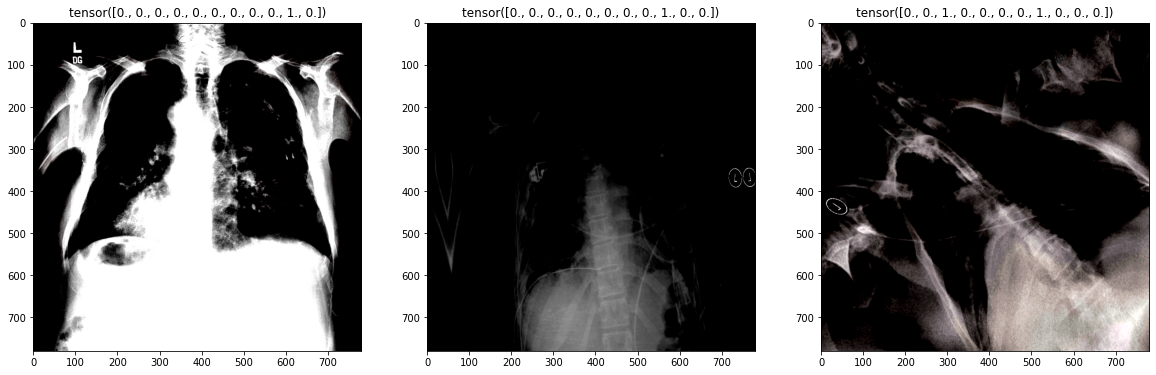

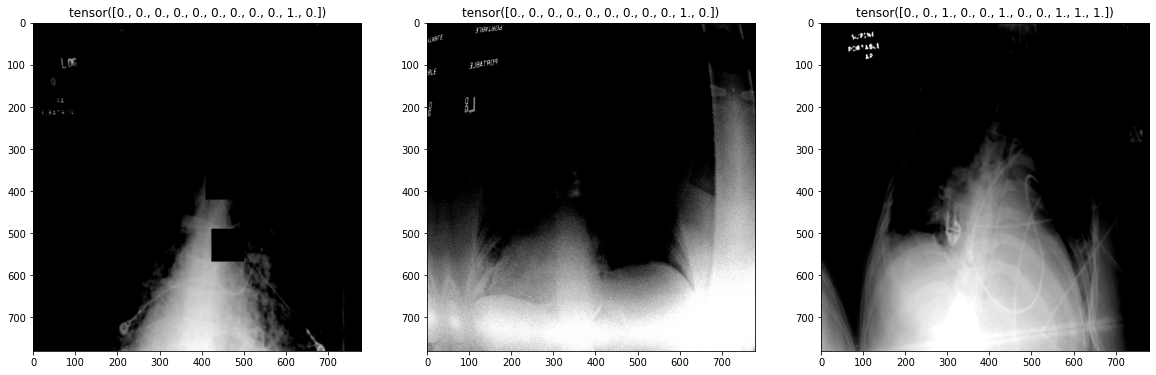

In [11]:
from pylab import rcParams
dataset_show = TrainDataset(train_df,
               transform=get_transforms(data='train') # None, get_transforms(data='check')
               )
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,3)
    for p in range(3):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        # axarr[p].imshow(img) # transform=None
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [12]:
class RanzcrClassifier(nn.Module):
    def __init__(self, model_arch, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)

        if 'efficientnet' in CFG.model_arch:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.n_class)
        elif "resnet" in CFG.model_arch:
            n_features = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(n_features, CFG.n_class)

    def forward(self, x):
        if 'efficientnet' in CFG.model_arch:
            return self.model(x)
        elif "resnet" in CFG.model_arch:
            bs = x.size(0)
            features = self.model(x)
            pooled_features = self.pooling(features).view(bs, -1)
            output = self.fc(pooled_features)
            return features, pooled_features, output

In [13]:
def get_activation(activ_name: str="relu"):
    """"""
    act_dict = {
        "relu": nn.ReLU(inplace=True),
        "tanh": nn.Tanh(),
        "sigmoid": nn.Sigmoid(),
        "identity": nn.Identity()}
    if activ_name in act_dict:
        return act_dict[activ_name]
    else:
        raise NotImplementedError
        

class Conv2dBNActiv(nn.Module):
    """Conv2d -> (BN ->) -> Activation"""
    
    def __init__(
        self, in_channels, out_channels,
        kernel_size, stride, padding,
        bias=False, use_bn=True, activ="relu"
    ):
        """"""
        super(Conv2dBNActiv, self).__init__()
        layers = []
        layers.append(nn.Conv2d(
            in_channels, out_channels,
            kernel_size, stride, padding, bias=bias))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(get_activation(activ))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward"""
        return self.layers(x)
        
    
class SpatialAttentionBlock(nn.Module):
    """Spatial Attention for (C, H, W) feature maps"""
    
    def __init__(
        self, in_channels,
        out_channels_list,
    ):
        """Initialize"""
        super(SpatialAttentionBlock, self).__init__()
        self.n_layers = len(out_channels_list)
        channels_list = [in_channels] + out_channels_list
        assert self.n_layers > 0
        assert channels_list[-1] == 1
        
        for i in range(self.n_layers - 1):
            in_chs, out_chs = channels_list[i: i + 2]
            layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="relu")
            setattr(self, f"conv{i + 1}", layer)
            
        in_chs, out_chs = channels_list[-2:]
        layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="sigmoid")
        setattr(self, f"conv{self.n_layers}", layer)
    
    def forward(self, x):
        """Forward"""
        h = x
        for i in range(self.n_layers):
            h = getattr(self, f"conv{i + 1}")(h)
            
        h = h * x
        return h



class MultiHeadResNet200D(nn.Module):
    def __init__(self, out_dims_head=[3, 4, 3, 1],  pretrained=False):
        self.base_name = "resnet200d_320"
        self.n_heads = len(out_dims_head)
        super(MultiHeadResNet200D, self).__init__()
        
        # # load base model
        base_model = timm.create_model(self.base_name, num_classes=sum(out_dims_head), pretrained=False)
        in_features = base_model.num_features
        
        if pretrained:
            pretrained_model_path = CFG.student
            state_dict = dict()
            for k, v in torch.load(pretrained_model_path, map_location='cpu')["model"].items():
                if k[:6] == "model.":
                    k = k.replace("model.", "")
                state_dict[k] = v
            base_model.load_state_dict(state_dict)
        
        # # remove global pooling and head classifier
        base_model.reset_classifier(0, '')
        
        # # Shared CNN Bacbone
        self.backbone = base_model
        
        # # Multi Heads.
        for i, out_dim in enumerate(out_dims_head):
            layer_name = f"head_{i}"
            layer = nn.Sequential(
                SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
                nn.AdaptiveAvgPool2d(output_size=1),
                nn.Flatten(start_dim=1),
                nn.Linear(in_features, in_features),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(in_features, out_dim))
            setattr(self, layer_name, layer)

    def forward(self, x):
        h = self.backbone(x)
        hs = [getattr(self, f"head_{i}")(h) for i in range(self.n_heads)]
        y = torch.cat(hs, axis=1)
        return None, None, y

In [14]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if CFG.device == 'GPU':
            with autocast():
                _, _, y_preds = model(images)
                loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            _, _, y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [15]:
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

# Scheduler

In [16]:
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss


# Training

In [18]:
def train_loop(df, fold, trn_idx, val_idx):
    loginfo(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = train_df.loc[trn_idx].reset_index(drop=True)
    valid_folds = train_df.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss
    # ====================================================
    # not checkpoint

    if CFG.multihead:
        model = MultiHeadResNet200D([3, 4, 3, 1], False).to(device)
        model.load_state_dict(torch.load(CFG.student)['model'])
    else:
        model = RanzcrClassifier(CFG.model_arch, pretrained=False).to(device)
        model.load_state_dict(torch.load(CFG.student, map_location=torch.device('cpu'))['model'])
 
    # optimizer
    if CFG.optimizer == "Adam":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = Adam(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV2":
        scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)
    elif CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    if CFG.loss_fn == "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.loss_fn == "FocalLoss":
        print("FocalLoss")
        criterion = FocalLoss().to(device)

    # ====================================================
    # loop
    # ====================================================
    valid_acc_max=0; valid_loss_min=float("inf")
    valid_acc_max_cnt=0; valid_loss_min_cnt=0;
    best_acc_epoch=0;


    for epoch in range(CFG.epochs):
        loginfo(f"***** Epoch {epoch} *****")
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")

                
        start_time = time.time()
        
        avg_loss, cur_lr = train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device) # train
        avg_val_loss, preds, _ = valid_one_epoch(valid_loader, model, criterion, device) # valid

        # scoring
        score, scores = get_score(valid_labels, preds)
        elapsed = time.time() - start_time


        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        # early stopping
        if score > valid_acc_max:
            valid_acc_max = score
            valid_acc_max_cnt=0
            best_acc_epoch = epoch
        else:
            valid_acc_max_cnt+=1

        if avg_val_loss < valid_loss_min:
            valid_loss_min = avg_val_loss
            valid_loss_min_cnt=0
        else:
            valid_loss_min_cnt+=1

        if valid_acc_max_cnt >= CFG.n_early_stopping and valid_loss_min_cnt >= CFG.n_early_stopping:
            cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
            if CFG.device == 'GPU':
                torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break

        cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')



    check_point = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    
    return valid_folds

In [19]:
def main():
    oof_df = pd.DataFrame()
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold in CFG.fold_list:
            _oof_df = train_loop(train_df, fold, trn_idx, val_idx)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
                
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_csv(outputdir+f'oof_df{CFG.suffix}.csv', index=False)

# Main

In [20]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========


1424


***** Epoch 0 *****
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-06


Epoch: [0][0/1504] Data 12.284 (12.284) Elapsed 0m 16s (remain 402m 49s) Loss: 0.1455(0.1455) Grad: 6652.8042  LR: 0.0000050  
Epoch: [0][100/1504] Data 0.000 (1.104) Elapsed 2m 39s (remain 36m 59s) Loss: 0.1816(0.1872) Grad: 8873.2979  LR: 0.0000050  
Epoch: [0][200/1504] Data 5.565 (0.996) Elapsed 4m 53s (remain 31m 41s) Loss: 0.2442(0.1839) Grad: 16321.7646  LR: 0.0000050  
Epoch: [0][300/1504] Data 0.000 (0.973) Elapsed 7m 9s (remain 28m 34s) Loss: 0.1463(0.1810) Grad: 8409.3799  LR: 0.0000050  
Epoch: [0][400/1504] Data 0.000 (0.973) Elapsed 9m 31s (remain 26m 12s) Loss: 0.1886(0.1793) Grad: 9390.1885  LR: 0.0000050  
Epoch: [0][500/1504] Data 0.000 (0.968) Elapsed 11m 51s (remain 23m 44s) Loss: 0.2201(0.1772) Grad: 10459.9268  LR: 0.0000050  
Epoch: [0][600/1504] Data 0.000 (0.988) Elapsed 14m 25s (remain 21m 40s) Loss: 0.1615(0.1746) Grad: 10370.9814  LR: 0.0000050  
Epoch: [0][700/1504] Data 7.415 (0.992) Elapsed 16m 49s (remain 19m 16s) Loss: 0.1833(0.1731) Grad: 15533.4971  L

Epoch 0 - avg_train_loss: 0.1621  avg_val_loss: 0.1183  time: 2250s
Epoch 0 - Score: 0.9686  Scores: [0.9937 0.9692 0.9933 0.9737 0.9735 0.9867 0.9887 0.9508 0.8859 0.94
 0.9996]
***** Epoch 1 *****
scheduler_last_epoch:1, scheduler_lr:4.757373726360927e-06
optimizer_lr:4.757373726360927e-06


Epoch: [1][0/1504] Data 14.900 (14.900) Elapsed 0m 15s (remain 384m 16s) Loss: 0.1816(0.1816) Grad: 13503.4023  LR: 0.0000048  
Epoch: [1][100/1504] Data 5.087 (1.039) Elapsed 2m 30s (remain 34m 47s) Loss: 0.1427(0.1515) Grad: 9180.3760  LR: 0.0000048  
Epoch: [1][200/1504] Data 0.000 (0.974) Elapsed 4m 47s (remain 31m 1s) Loss: 0.1373(0.1507) Grad: 11990.4824  LR: 0.0000048  
Epoch: [1][300/1504] Data 0.000 (0.969) Elapsed 7m 9s (remain 28m 37s) Loss: 0.0783(0.1494) Grad: 9168.0088  LR: 0.0000048  
Epoch: [1][400/1504] Data 0.000 (0.945) Elapsed 9m 21s (remain 25m 44s) Loss: 0.1622(0.1502) Grad: 14884.5098  LR: 0.0000048  
Epoch: [1][500/1504] Data 0.000 (0.945) Elapsed 11m 40s (remain 23m 23s) Loss: 0.1942(0.1483) Grad: 21137.5840  LR: 0.0000048  
Epoch: [1][600/1504] Data 0.000 (0.940) Elapsed 13m 56s (remain 20m 57s) Loss: 0.0848(0.1482) Grad: 16881.6152  LR: 0.0000048  
Epoch: [1][700/1504] Data 0.008 (0.940) Elapsed 16m 16s (remain 18m 38s) Loss: 0.1076(0.1477) Grad: 10930.1963  

Epoch 1 - avg_train_loss: 0.1465  avg_val_loss: 0.1141  time: 2186s
Epoch 1 - Score: 0.9688  Scores: [0.9945 0.9691 0.9934 0.9734 0.9733 0.9869 0.9888 0.9516 0.8866 0.9399
 0.9996]


EVAL: [188/189] Data 0.000 (0.139) Elapsed 1m 36s (remain 0m 0s) Loss: 0.3149(0.1141) 


***** Epoch 2 *****
scheduler_last_epoch:2, scheduler_lr:4.077550014553898e-06
optimizer_lr:4.077550014553898e-06


Epoch: [2][0/1504] Data 13.867 (13.867) Elapsed 0m 14s (remain 360m 22s) Loss: 0.1104(0.1104) Grad: 14094.4111  LR: 0.0000041  
Epoch: [2][100/1504] Data 0.010 (1.052) Elapsed 2m 31s (remain 34m 59s) Loss: 0.1472(0.1406) Grad: 14421.0400  LR: 0.0000041  
Epoch: [2][200/1504] Data 0.000 (1.059) Elapsed 5m 1s (remain 32m 37s) Loss: 0.1285(0.1366) Grad: 13033.6426  LR: 0.0000041  
Epoch: [2][300/1504] Data 0.000 (0.983) Elapsed 7m 10s (remain 28m 40s) Loss: 0.1236(0.1377) Grad: 17612.5469  LR: 0.0000041  
Epoch: [2][400/1504] Data 0.000 (0.968) Elapsed 9m 28s (remain 26m 3s) Loss: 0.1296(0.1403) Grad: 21066.3047  LR: 0.0000041  
Epoch: [2][500/1504] Data 0.000 (0.965) Elapsed 11m 47s (remain 23m 37s) Loss: 0.2482(0.1409) Grad: 28546.4102  LR: 0.0000041  
Epoch: [2][600/1504] Data 0.000 (0.946) Elapsed 13m 59s (remain 21m 1s) Loss: 0.1179(0.1412) Grad: 9825.4209  LR: 0.0000041  
Epoch: [2][700/1504] Data 7.678 (0.960) Elapsed 16m 29s (remain 18m 53s) Loss: 0.1004(0.1420) Grad: 12463.7012  

Epoch 2 - avg_train_loss: 0.1427  avg_val_loss: 0.1131  time: 2170s
Epoch 2 - Score: 0.9689  Scores: [0.9946 0.9693 0.9933 0.9732 0.9731 0.9869 0.9888 0.9522 0.8871 0.9401
 0.9996]


EVAL: [188/189] Data 0.000 (0.135) Elapsed 1m 35s (remain 0m 0s) Loss: 0.3504(0.1131) 


***** Epoch 3 *****
scheduler_last_epoch:3, scheduler_lr:3.0951762881929706e-06
optimizer_lr:3.0951762881929706e-06


Epoch: [3][0/1504] Data 8.637 (8.637) Elapsed 0m 9s (remain 231m 24s) Loss: 0.1519(0.1519) Grad: 22825.8945  LR: 0.0000031  
Epoch: [3][100/1504] Data 0.000 (0.920) Elapsed 2m 18s (remain 32m 10s) Loss: 0.1300(0.1423) Grad: 15538.7188  LR: 0.0000031  
Epoch: [3][200/1504] Data 3.424 (0.910) Elapsed 4m 34s (remain 29m 38s) Loss: 0.1524(0.1418) Grad: 14458.9033  LR: 0.0000031  
Epoch: [3][300/1504] Data 0.000 (0.918) Elapsed 6m 52s (remain 27m 29s) Loss: 0.1541(0.1414) Grad: 19609.2461  LR: 0.0000031  
Epoch: [3][400/1504] Data 0.000 (0.952) Elapsed 9m 21s (remain 25m 43s) Loss: 0.1480(0.1395) Grad: 20606.1191  LR: 0.0000031  
Epoch: [3][500/1504] Data 0.011 (0.957) Elapsed 11m 44s (remain 23m 30s) Loss: 0.0824(0.1392) Grad: 9600.3457  LR: 0.0000031  
Epoch: [3][600/1504] Data 0.000 (0.959) Elapsed 14m 7s (remain 21m 13s) Loss: 0.1604(0.1400) Grad: 16282.9443  LR: 0.0000031  
Epoch: [3][700/1504] Data 0.000 (0.967) Elapsed 16m 33s (remain 18m 58s) Loss: 0.1271(0.1405) Grad: 18165.0293  L

Epoch 3 - avg_train_loss: 0.1412  avg_val_loss: 0.1128  time: 2188s
Epoch 3 - Score: 0.9689  Scores: [0.9945 0.9693 0.9933 0.973  0.9734 0.9869 0.9889 0.952  0.8871 0.9401
 0.9996]


EVAL: [188/189] Data 0.000 (0.130) Elapsed 1m 34s (remain 0m 0s) Loss: 0.3823(0.1128) 


***** Epoch 4 *****
scheduler_last_epoch:4, scheduler_lr:2.00482371180703e-06
optimizer_lr:2.00482371180703e-06


Epoch: [4][0/1504] Data 12.565 (12.565) Elapsed 0m 13s (remain 326m 11s) Loss: 0.1566(0.1566) Grad: 19301.4121  LR: 0.0000020  
Epoch: [4][100/1504] Data 0.000 (1.011) Elapsed 2m 29s (remain 34m 29s) Loss: 0.1403(0.1434) Grad: 14525.1387  LR: 0.0000020  
Epoch: [4][200/1504] Data 2.244 (0.970) Elapsed 4m 49s (remain 31m 13s) Loss: 0.1108(0.1389) Grad: 11593.1504  LR: 0.0000020  
Epoch: [4][300/1504] Data 0.000 (0.945) Elapsed 7m 2s (remain 28m 10s) Loss: 0.1419(0.1387) Grad: 23310.5059  LR: 0.0000020  
Epoch: [4][400/1504] Data 0.000 (0.928) Elapsed 9m 17s (remain 25m 33s) Loss: 0.2241(0.1424) Grad: 17577.9043  LR: 0.0000020  
Epoch: [4][500/1504] Data 0.000 (0.930) Elapsed 11m 38s (remain 23m 18s) Loss: 0.1487(0.1428) Grad: 12971.2129  LR: 0.0000020  
Epoch: [4][600/1504] Data 0.000 (0.934) Elapsed 13m 58s (remain 21m 0s) Loss: 0.1134(0.1422) Grad: 13631.4092  LR: 0.0000020  
Epoch: [4][700/1504] Data 0.000 (0.940) Elapsed 16m 19s (remain 18m 42s) Loss: 0.1244(0.1424) Grad: 20895.2051

Epoch 4 - avg_train_loss: 0.1416  avg_val_loss: 0.1127  time: 2194s
Epoch 4 - Score: 0.9690  Scores: [0.9945 0.9695 0.9933 0.9731 0.9734 0.9869 0.9889 0.9522 0.8872 0.9403
 0.9996]


EVAL: [188/189] Data 0.000 (0.132) Elapsed 1m 34s (remain 0m 0s) Loss: 0.3735(0.1127) 


***** Epoch 5 *****
scheduler_last_epoch:5, scheduler_lr:1.0224499854461031e-06
optimizer_lr:1.0224499854461031e-06


Epoch: [5][0/1504] Data 15.865 (15.865) Elapsed 0m 16s (remain 411m 11s) Loss: 0.1302(0.1302) Grad: 13374.0156  LR: 0.0000010  
Epoch: [5][100/1504] Data 0.000 (1.015) Elapsed 2m 29s (remain 34m 35s) Loss: 0.1233(0.1414) Grad: 16048.9648  LR: 0.0000010  
Epoch: [5][200/1504] Data 0.003 (0.948) Elapsed 4m 41s (remain 30m 21s) Loss: 0.1930(0.1404) Grad: 18278.8496  LR: 0.0000010  
Epoch: [5][300/1504] Data 0.000 (0.943) Elapsed 7m 0s (remain 28m 0s) Loss: 0.1658(0.1404) Grad: 17666.4473  LR: 0.0000010  
Epoch: [5][400/1504] Data 0.000 (0.933) Elapsed 9m 14s (remain 25m 24s) Loss: 0.0756(0.1427) Grad: 12530.7773  LR: 0.0000010  
Epoch: [5][500/1504] Data 0.000 (0.918) Elapsed 11m 26s (remain 22m 53s) Loss: 0.1209(0.1437) Grad: 13966.7109  LR: 0.0000010  
Epoch: [5][600/1504] Data 0.000 (0.909) Elapsed 13m 38s (remain 20m 30s) Loss: 0.1294(0.1422) Grad: 16030.7520  LR: 0.0000010  
Epoch: [5][700/1504] Data 0.005 (0.916) Elapsed 15m 59s (remain 18m 19s) Loss: 0.1297(0.1413) Grad: 13910.1250

Epoch 5 - avg_train_loss: 0.1407  avg_val_loss: 0.1126  time: 2154s
Epoch 5 - Score: 0.9690  Scores: [0.9946 0.9694 0.9933 0.9731 0.9736 0.987  0.9889 0.952  0.8872 0.9401
 0.9996]


EVAL: [188/189] Data 0.000 (0.135) Elapsed 1m 35s (remain 0m 0s) Loss: 0.3867(0.1126) 


***** Epoch 6 *****
scheduler_last_epoch:6, scheduler_lr:3.426262736390734e-07
optimizer_lr:3.426262736390734e-07


Epoch: [6][0/1504] Data 10.689 (10.689) Elapsed 0m 11s (remain 279m 31s) Loss: 0.1231(0.1231) Grad: 15272.2051  LR: 0.0000003  
Epoch: [6][100/1504] Data 3.333 (1.036) Elapsed 2m 31s (remain 35m 1s) Loss: 0.0955(0.1408) Grad: 13779.7422  LR: 0.0000003  
Epoch: [6][200/1504] Data 0.000 (0.987) Elapsed 4m 49s (remain 31m 17s) Loss: 0.1600(0.1401) Grad: 20432.8008  LR: 0.0000003  
Epoch: [6][300/1504] Data 4.005 (0.999) Elapsed 7m 18s (remain 29m 10s) Loss: 0.1377(0.1368) Grad: 17599.7031  LR: 0.0000003  
Epoch: [6][400/1504] Data 6.359 (0.993) Elapsed 9m 40s (remain 26m 36s) Loss: 0.1409(0.1379) Grad: 15446.9053  LR: 0.0000003  
Epoch: [6][500/1504] Data 0.003 (0.968) Elapsed 11m 53s (remain 23m 47s) Loss: 0.1279(0.1393) Grad: 14122.9746  LR: 0.0000003  
Epoch: [6][600/1504] Data 0.000 (0.971) Elapsed 14m 15s (remain 21m 24s) Loss: 0.1254(0.1401) Grad: 11428.2734  LR: 0.0000003  
Epoch: [6][700/1504] Data 0.000 (0.965) Elapsed 16m 33s (remain 18m 58s) Loss: 0.1897(0.1402) Grad: 24420.835

Epoch 6 - avg_train_loss: 0.1396  avg_val_loss: 0.1127  time: 2173s
Epoch 6 - Score: 0.9689  Scores: [0.9946 0.9693 0.9933 0.9727 0.973  0.9869 0.9889 0.9521 0.8875 0.9401
 0.9996]


EVAL: [188/189] Data 0.000 (0.133) Elapsed 1m 34s (remain 0m 0s) Loss: 0.4040(0.1127) 


***** Epoch 7 *****
scheduler_last_epoch:7, scheduler_lr:1e-07
optimizer_lr:1e-07


Epoch: [7][0/1504] Data 14.903 (14.903) Elapsed 0m 15s (remain 384m 31s) Loss: 0.1544(0.1544) Grad: 15293.9756  LR: 0.0000001  
Epoch: [7][100/1504] Data 2.762 (0.966) Elapsed 2m 25s (remain 33m 37s) Loss: 0.1566(0.1396) Grad: 15304.6924  LR: 0.0000001  
Epoch: [7][200/1504] Data 0.000 (0.981) Elapsed 4m 51s (remain 31m 31s) Loss: 0.0887(0.1402) Grad: 11521.4121  LR: 0.0000001  
Epoch: [7][300/1504] Data 0.000 (1.013) Elapsed 7m 24s (remain 29m 35s) Loss: 0.2158(0.1411) Grad: 23166.5078  LR: 0.0000001  
Epoch: [7][400/1504] Data 0.000 (1.016) Elapsed 9m 51s (remain 27m 5s) Loss: 0.1461(0.1405) Grad: 15106.1689  LR: 0.0000001  
Epoch: [7][500/1504] Data 0.000 (0.993) Elapsed 12m 5s (remain 24m 13s) Loss: 0.1075(0.1407) Grad: 15731.9697  LR: 0.0000001  
Epoch: [7][600/1504] Data 0.000 (0.994) Elapsed 14m 31s (remain 21m 49s) Loss: 0.1555(0.1408) Grad: 14200.0713  LR: 0.0000001  
Epoch: [7][700/1504] Data 0.003 (0.980) Elapsed 16m 45s (remain 19m 12s) Loss: 0.1773(0.1410) Grad: 18397.1992

Epoch 7 - avg_train_loss: 0.1410  avg_val_loss: 0.1125  time: 2196s
Epoch 7 - Score: 0.9691  Scores: [0.9948 0.9696 0.9933 0.9733 0.9735 0.987  0.9889 0.952  0.8876 0.9401
 0.9995]


EVAL: [188/189] Data 0.000 (0.132) Elapsed 1m 34s (remain 0m 0s) Loss: 0.3808(0.1125) 


========== fold: 0 result ==========
Score: 0.9691  Scores: [0.9948 0.9696 0.9933 0.9733 0.9735 0.987  0.9889 0.952  0.8876 0.9401
 0.9995]
========== CV ==========
Score: 0.9691  Scores: [0.9948 0.9696 0.9933 0.9733 0.9735 0.987  0.9889 0.952  0.8876 0.9401
 0.9995]


In [21]:
# save as cpu
if CFG.device == 'TPU':
    for fold in range(CFG.fold_num): 
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}_cpu.pth')